<a href="https://colab.research.google.com/github/rajatdhanotiya/Bike-Sharing-Demand-Prediction/blob/master/Bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment=None
#warnings.filterwarnings("ignore", catagory=DeprecationWarning)
%matplotlib inline
import os


In [0]:
BikeData=pd.read_csv('/content/gdrive/My Drive/BikeSharing/train.csv')

In [50]:
BikeData.shape

(10886, 12)

In [51]:
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [52]:
BikeData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [53]:
BikeData['datetime'] = BikeData['datetime'].apply(pd.to_datetime)

# Extract year, month, day and time from the datetime type
BikeData['year'] = BikeData['datetime'].apply(lambda x : x.year)
BikeData['month'] = BikeData['datetime'].apply(lambda x : x.month)
BikeData['day'] = BikeData['datetime'].apply(lambda x : x.day)
BikeData['hour'] = BikeData['datetime'].apply(lambda x : x.hour)
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [0]:
BikeData=BikeData.drop(["datetime",'casual','registered'],axis=1)

In [0]:
from sklearn.metrics import mean_squared_error , mean_absolute_error


#calculate rmsle
def rmsle(y,pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle
  
#calculate rmse
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

#calculate MSE,RMSE,RMSLE

def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mse_val=mean_absolute_error(y,pred)
    print('RMSLE: {:.3f}, RMSE: {:.3f}, MSE: {:.3f}'.format(rmsle_val,rmse_val,mse_val))

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target=BikeData['count']
X_features=BikeData.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=2019)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.185, RMSE: 142.795, MSE: 107.172


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys


In [57]:
#considering actual and predicted values in top 5 errors

def get_top_error_data(y_test,pred,n_tops=5):
  result_df=pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count']=np.round(pred)
  result_df['diff']=np.abs(result_df['real_count'] - result_df['predicted_count'])                       
  print(result_df.sort_values('diff', ascending = False)[:n_tops])
                           
get_top_error_data(y_test, pred , n_tops=5)

      real_count  predicted_count   diff
1138         839            200.0  639.0
2297         784            179.0  605.0
435          948            361.0  587.0
2024         890            321.0  569.0
3251         884            321.0  563.0


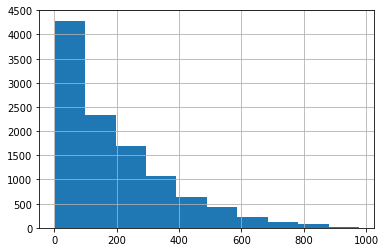

In [58]:
y_target.hist()

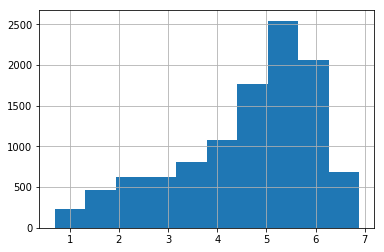

In [59]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [60]:
y_target_log=np.log1p(y_target)

X_train,X_test,y_train,y_test = train_test_split(X_features, y_target_log,test_size=0.3,random_state=2019)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

#convert the transformed y_test values into the original values

y_test_exp=np.expm1(y_test)

#convert transformed predicted values into the original values

pred_exp=np.expm1(pred)


evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.022, RMSE: 160.071, MSE: 106.316


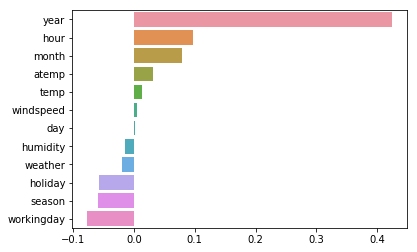

In [61]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending= False)
sn.barplot(x=coef_sort.values, y=coef_sort.index)

In [0]:
#year feature has an exceptional coefficient value
# so categorical features including year need to be transformed into one-hot encoding 

X_features_ohe=pd.get_dummies(X_features,columns=['year','month','hour','holiday','workingday','season','weather'])

In [63]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0


In [70]:
X_train,X_test,y_train,y_test = train_test_split(X_features_ohe , y_target_log, test_size=0.3,random_state=2019)

def get_model_predict(model, X_train, X_test,y_train, y_test,is_expm1=False):
  model.fit(X_train,y_train)
  pred=model.predict(X_test)
  if is_expm1:
    y_test=np.expm1(y_test)
    pred=np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test,pred)
  
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train,X_test,y_train, y_test, is_expm1=True)
  

### LinearRegression ###
RMSLE: 0.592, RMSE: 95.034, MSE: 61.505
### Ridge ###
RMSLE: 0.594, RMSE: 96.272, MSE: 62.192
### Lasso ###
RMSLE: 0.644, RMSE: 111.825, MSE: 71.792


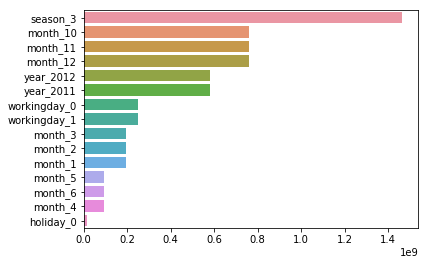

In [73]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:15]
sn.barplot(x=coef_sort.values, y=coef_sort.index)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=2019)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
lgbm_reg=LGBMRegressor(n_estimators=500)

for model in[rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
  get_model_predict(model, X_train, X_test,y_train, y_test, is_expm1=True)


### RandomForestRegressor ###
RMSLE: 0.358, RMSE: 49.006, MSE: 31.102
### GradientBoostingRegressor ###
RMSLE: 0.338, RMSE: 51.747, MSE: 32.229
[15:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.202, MSE: 31.965
### LGBMRegressor ###
RMSLE: 0.316, RMSE: 44.409, MSE: 27.462


In [0]:
submission= pd.read_csv('/content/gdrive/My Drive/BikeSharing/sampleSubmission.csv')

In [79]:
submission.shape

(6493, 2)

In [80]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [83]:
X_test=pd.read_csv('/content/gdrive/My Drive/BikeSharing/test.csv')
X_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [85]:
X_test.shape

(6493, 9)

In [86]:
# Transform string into datetime type
X_test['datetime'] = X_test['datetime'].apply(pd.to_datetime)

# Extract year, month, day and time from the datetime type
X_test['year'] = X_test['datetime'].apply(lambda x : x.year)
X_test['month'] = X_test['datetime'].apply(lambda x : x.month)
X_test['day'] = X_test['datetime'].apply(lambda x : x.day)
X_test['hour'] = X_test['datetime'].apply(lambda x : x.hour)
X_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [87]:
X_test.drop(['datetime'], axis=1, inplace=True)
X_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [88]:
X_test.shape

(6493, 12)

In [89]:
X_test_ohe = pd.get_dummies(X_test, columns=['year', 'month', 'hour', 'holiday', 'workingday', 'season', 'weather'])
X_test_ohe.head()

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,10.66,11.365,56,26.0027,20,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
1,10.66,13.635,56,0.0000,20,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
2,10.66,13.635,56,0.0000,20,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
3,10.66,12.880,56,11.0014,20,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
4,10.66,12.880,56,11.0014,20,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0


In [0]:
prediction=lgbm_reg.predict(X_test_ohe)

In [92]:
prediction

array([2.46911298, 1.47993393, 1.32077378, ..., 4.78598733, 4.49582594,
       3.88310577])

In [0]:
submission['count']=np.round(prediction,0).astype(int)

In [94]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,2
1,2011-01-20 01:00:00,1
2,2011-01-20 02:00:00,1
3,2011-01-20 03:00:00,1
4,2011-01-20 04:00:00,1


In [0]:
submission.to_csv('/content/gdrive/My Drive/BikeSharing/Mysubmissions.csv',index=False)